# <center>M2 DAC -   Reinforcement Learning & Advanced Deep</center>
##  <center> TME 9. Generative Adversarial Networks  </center>

Ce TME a pour objectif d'expérimenter les Generative Adversarial Networks
(GANs) sur un problème de génération de visages.

De manière classique, un GAN se formule selon un problème adverse de la
manière suivante: $$\min\limits_{G} \max\limits_D V(D,G) = \mathbb{E}_{x\sim
p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim
p_{z}(z)}\big[log(1-D(G(z)))\big]$$ Cette formulation met en jeu deux réseaux
adverse:
*   Un réseau discriminateur $D$, dont l'objectif est de savoir distinguer les
    données réelles des données simulées
*   Un réseau générateur $G$, dont l'objectif est de flouer le discriminateur

À l'optimum, avec des réseaux de capacité infinie, la distribution $p_G$ des
données générées par $G$ est prouvée suivre la distribution des données
réelles $p_{data}$. Bien sûr nous ne travaillons pas avec des réseaux de
capacité infinie (et d'ailleurs heureusement car on ne veut pas apprendre par
coeur les données d'apprentissage), mais l'objectif est d'approcher cette
distribution $p_{data}$ en apprenant un générateur neuronal dont les sorties
sont difficilement distinguables des vraies données pour le discriminateur.

Nous proposons de mettre ce genre d'architecture pour un la génération de
visages: selon un ensemble de visages d'entraînement, il s'agit d'apprendre à
générer des visages qui paraissent les plus réalistes possibles tout en
conservant une certaine diversité dans les distributions de sortie. Pour cela
nous emploierons une architecture DCGAN, qui utilise des réseaux de neurones
convolutionnels (CNNs) pour le générateur et le discriminateur.


In [1]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn

import os

2023-12-04 14:14:26.817840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 14:14:26.946951: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 14:14:28.084175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /Infos/bd/client11/instantclient_11_2:/Infos/lmd/2021/licence/ue/LU3IN029-2021oct/kO6/bin/gcc/lib64:/Infos/bd/client11/instantclient_11_2:/Infos/lmd/2021/licence/ue/LU3IN029-2021oct/kO6/bin/gcc/lib64::/usr/local/

In [2]:
cache_dir = os.environ.get(
    "TORCHVISION_CACHE", os.path.expanduser("~/.cache/torchvision")
)
cache_dir

'/users/nfs/Enseignants/piwowarski/.cache/torchvision'


Le code ci-dessous permet de déclarer la manière de charger les données.

Lorsque des données sont demandées (pour la construction d'un nouveau batch
par exemple), une série de transformations est appliquée sur les images, selon
la composition de transformateurs déclarée pour le chargement:
*    redimentionnement des images en 64 par 64
*    recadrage au centre (qui ne fait rien ici car image déjà dans la taille
     du cadre mais si utile pour d'autres paramètres)
*    conversion en tenseur pytorch
*    normalisation des valeurs RGB selon une moyenne de 0.5 et un ecart-type
     de 0.5.



In [3]:
image_size = 64
dataset = dset.CelebA(
    root=cache_dir,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    download=True,
)

print(dataset)

Files already downloaded and verified
Dataset CelebA
    Number of datapoints: 162770
    Root location: /users/nfs/Enseignants/piwowarski/.cache/torchvision
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )



Le code ci-dessous permet de déclarer la manière de charger les images et en
affiche un échantillon.

Running on CUDA


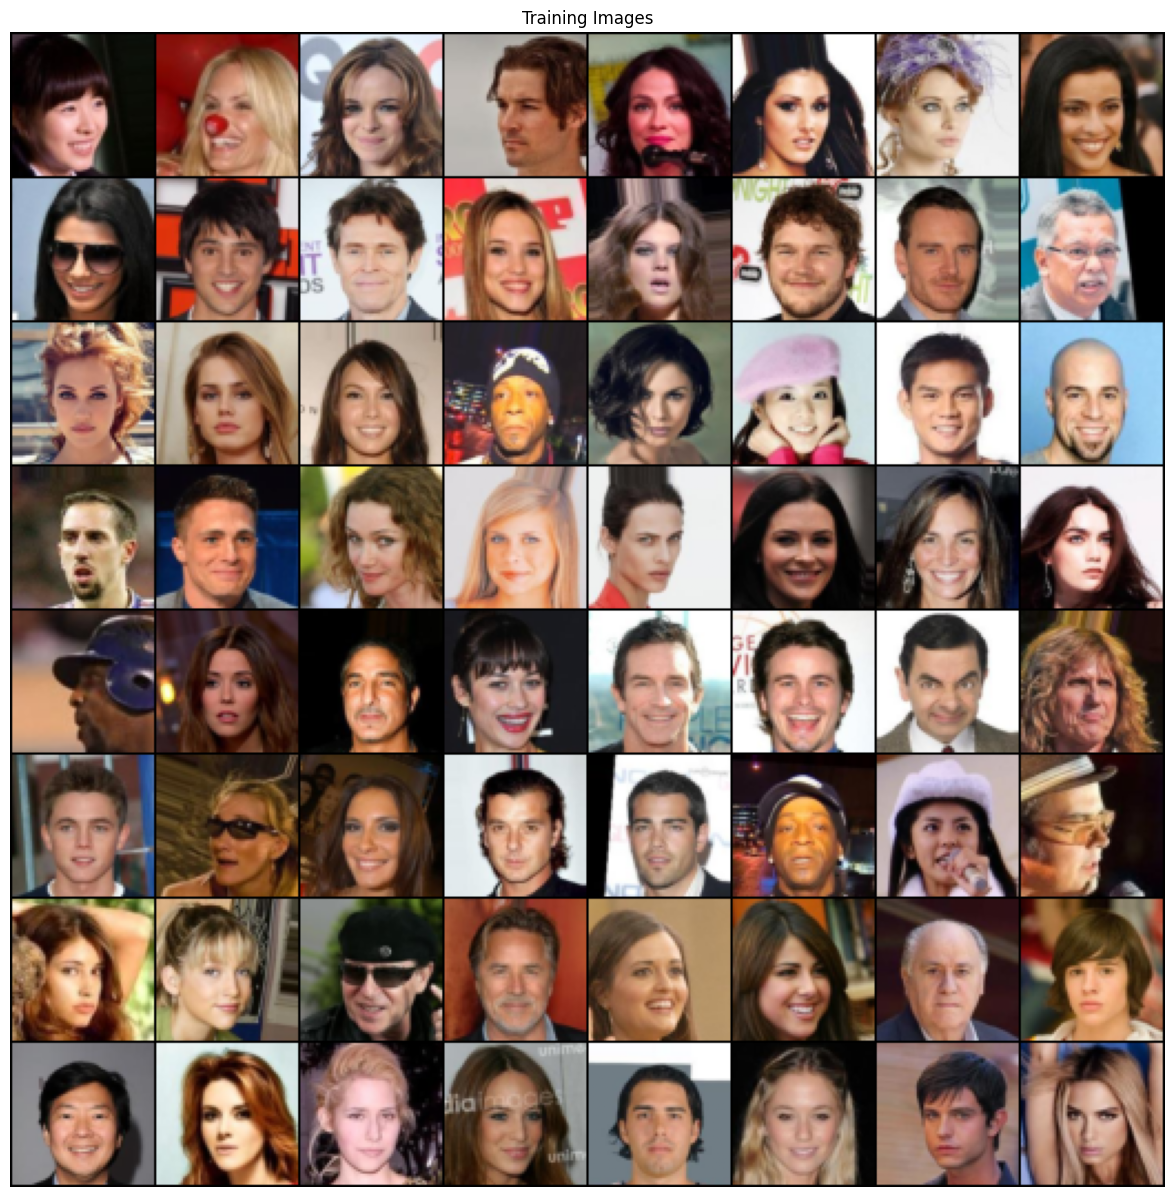

In [4]:
import matplotlib.pyplot as plt
import os


seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    print("Running on CUDA")
    cudnn.benchmark = True
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(seed)
elif torch.backends.mps.is_available():
    print("Running on MPS")
    device = torch.device("mps")
else:
    print("WARNING: running on CPU")
    device = torch.device("cpu")

batch_size = 128
workers = 2

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Affichage de quelques images
real_batch = next(
    iter(dataloader)
)  # real_batch est une liste de 2 tenseurs où le 1er correspond aux images, les second correspond aux labels (ici 0 partout)

plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=1, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)
os.makedirs("genFaces", exist_ok=True)
plt.savefig(
    "genFaces/train.png"
)  # Pour sauvegarder l'image sur votre Google Drive


Le réseau $D$ est un empilement de couches de convolution 2D avec batchNorm2D
et activations RELU:

In [5]:

# Nombre de canaux de l'entrée
nc = 3

# Facteur du nombre de canaux de sortie des différentes couches de convolution
ndf = 64  


# Initialisation recommandee pour netG et netD dans DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [6]:
nz = 100  # Taille du vecteur z donné en entrée du générateur
ngf = (
    64  # Facteur du nombre de canaux de sortie des différentes couches de déconvolution
)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)



Donner la procédure d'entraînement de ces deux réseaux. L'optimisation se fera
ADAM selon les deux coûts adverses du discriminateur et du générateur. Pour
chaque nouveau batch d'images, on alterne les deux mises à jour suivantes,
selon un batch de vecteurs $z$ tirés aléatoirement selon une loi normale
centrée réduite (un nouveau batch de $z$ à chaque itération):

1.   Un pas de gradient sur les paramètres du réseau D pour maximiser:
     $log(D(x)) + log(1 - D(G(z)))$
2.   Un pas de gradient sur les paramètres du réseau G pour minimiser:
     $log(1-D(G(z)))$


Afin de suivre l'évolution de l'apprentissage, on pourra logguer l'erreur du
discriminateur relevée en 1, l'erreur du générateur relevée en 2, la moyenne
des sorties du discriminateur sur les images réelles et la moyenne des sorties
du discriminateur sur les images générées.

À la fin de chaque époque (i.e., lorsque l'on a itéré sur tous les batchs du
DataLoader), on pourra enregistrer les images générées à partir d'un batch de
vecteurs $z$ fixe dans le Google Drive pour observer l'évolution des capacités
du générateur.

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

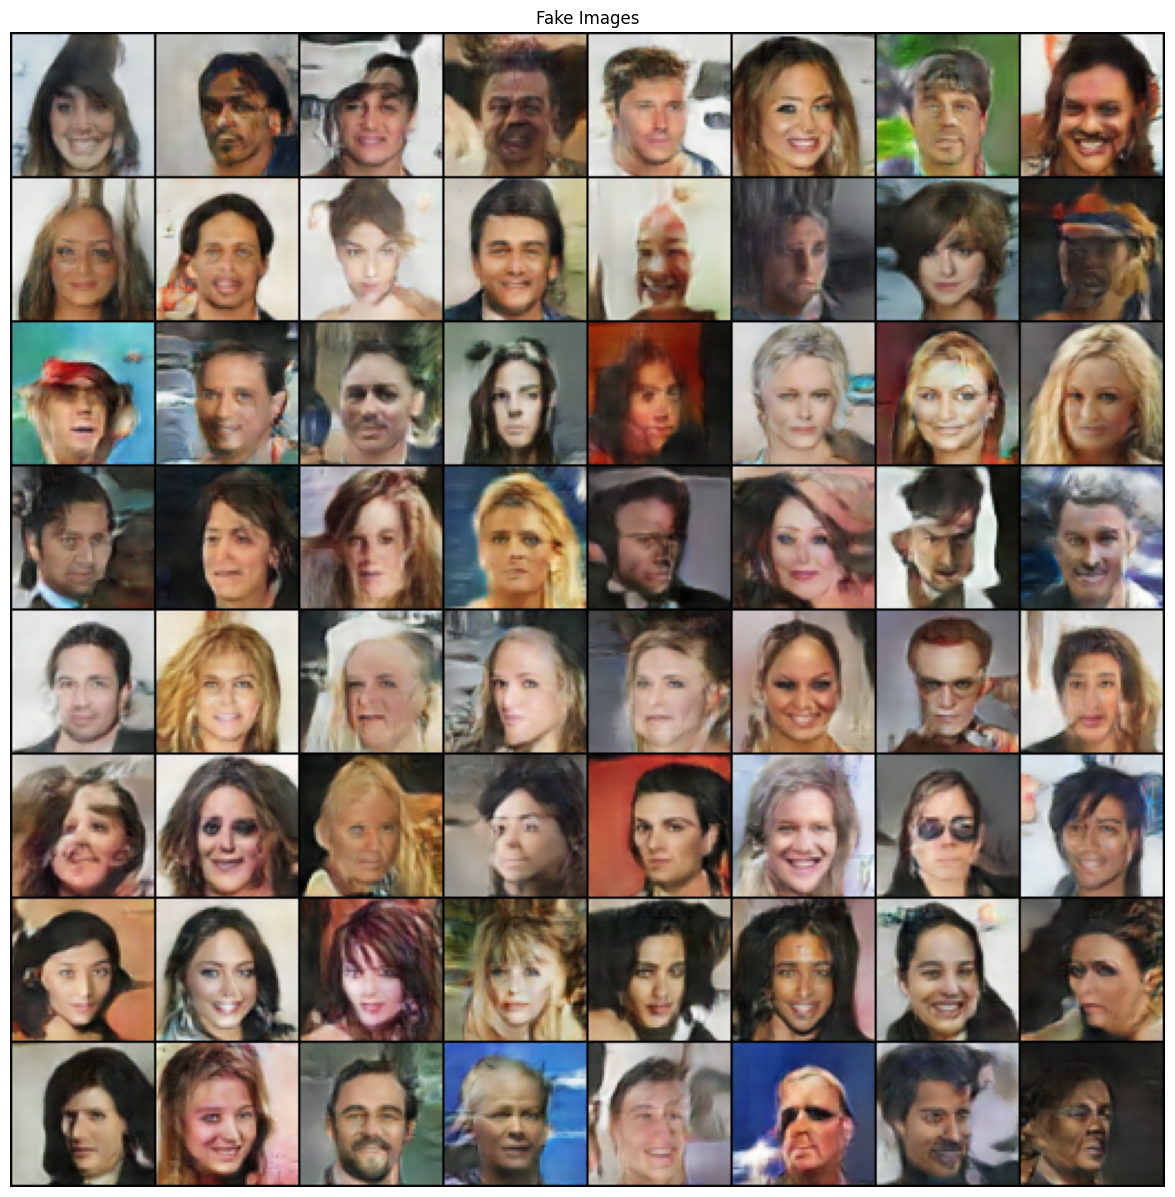

In [13]:
import logging
from tqdm.autonotebook import tqdm

logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s %(levelname)s %(message)s',
                    handlers=[logging.FileHandler("GAN.log"),
                              logging.StreamHandler()])


epochs = 10
lr = 0.0002

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in tqdm(range(epochs)):
    for i, data in tqdm(enumerate(dataloader, 0)):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, device=device, dtype=torch.float)
        output = netD(real_cpu).view(-1)
        errD_real = F.binary_cross_entropy(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach()).view(-1)
        errD_fake = F.binary_cross_entropy(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(1)
        output = netD(fake).view(-1)
        errG = F.binary_cross_entropy(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()


        if i % 50 == 0:
            logging.info(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    epochs,
                    i,
                    len(dataloader),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )

        if i % 500 == 0:
            vutils.save_image(
                real_cpu,
                "%s/real_samples.png" % "genFaces",
                normalize=True,
            )
            fake = netG(fixed_noise)
            vutils.save_image(
                fake.detach(),
                "%s/fake_samples_epoch_%03d.png" % ("genFaces", epoch),
                normalize=True,
            )

# Affichage de quelques images générées
real_batch = next(iter(dataloader))
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            fake.detach()[:64], padding=1, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

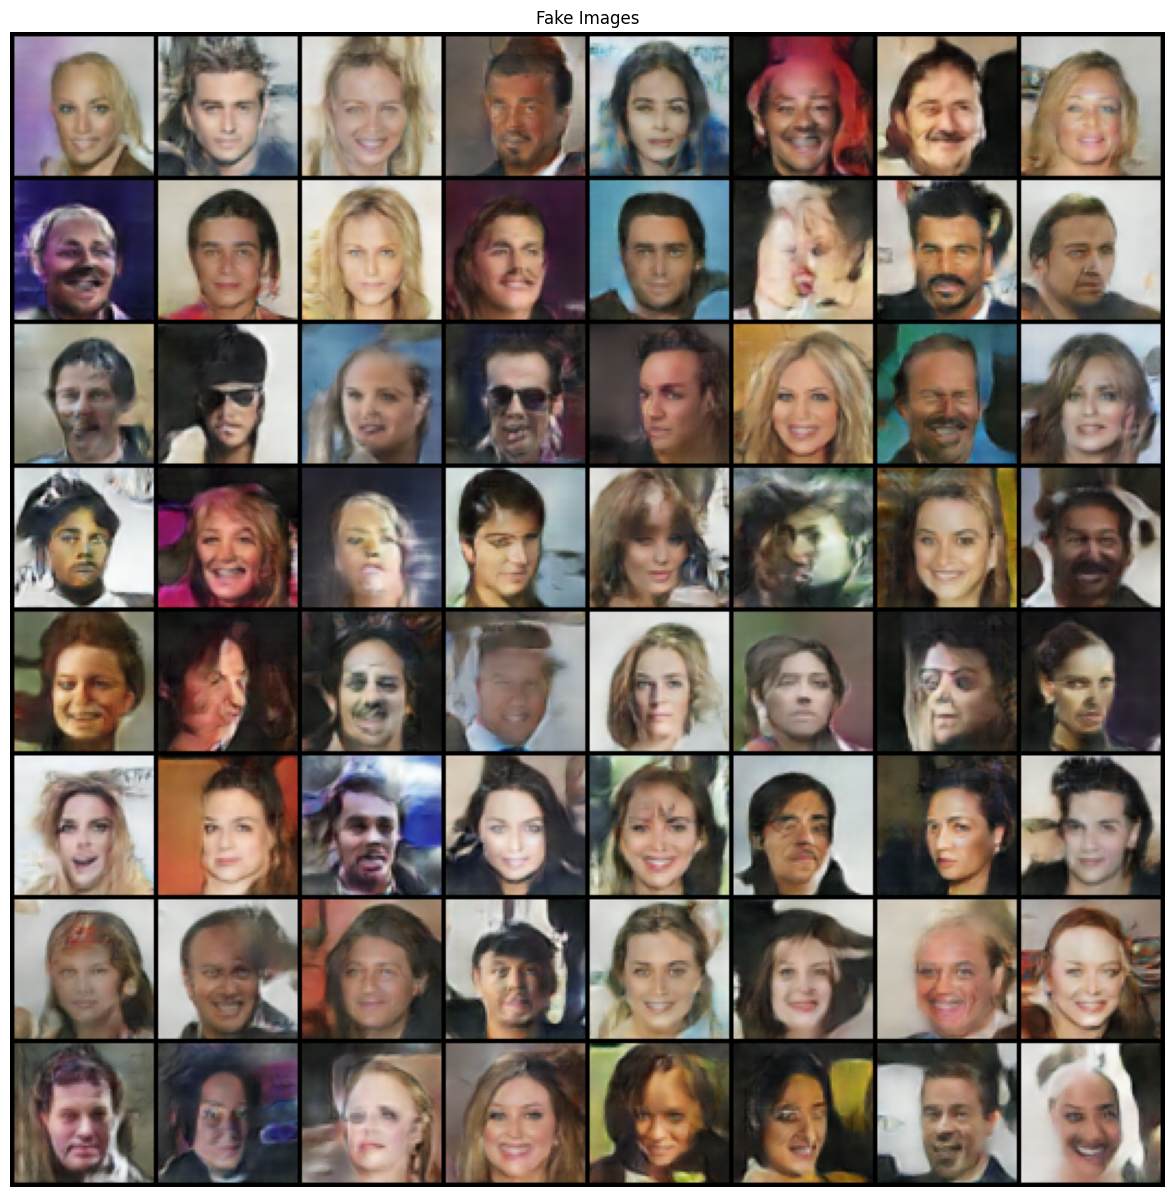

In [15]:

# Le code ci-dessous applique votre réseau à un
# batch de $z$ aléatoires et affiche les images générées (et enregistre dans
# fake.png).
img_list = []
noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    netG.eval()
    fake = netG(noise).detach().cpu()
img = vutils.make_grid(fake, padding=2, normalize=True)
img_list.append(img)
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))
plt.savefig("fake.png")

# Bonus: Générateur

Le générateur du papier original DCGAN possède en fait l'architecture
suivante:

![Generator](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Comme le réseau $G$ définit plus haut, il correspond à un empilement de
couches de convolutions transposées (appelée dans certains papiers couches de
déconvolution). Contrairement aux convolutions classiques qui mènent à une
réduction de la taille des sorties, les convolutions transposées agrandissent
les cartes de caractéristiques considérées (feature maps). C'est
particulièrement adapté pour de la génération d'images à partir d'un code de
petite taille (ici $z$).

 Pour comprendre comment fonctionne la convolution transposée, voici un
 exemple simple avec une entrée 2 x 2 et un noyau 2 x 2. Chaque élément de
 l'entrée (4 éléments) est multiplié par le noyau et le résultat est ajouté à
 la sorte de taille 3 x 3:

![BasicTransposeConv2D](https://d2l.ai/_images/trans_conv.svg)

Et voici deux animations pour se représenter l'opération d'une manière plus
générale. A gauche on utilise un stride de 1, à droite un stride de 2:

<p align="center">
<img src="https://i.stack.imgur.com/YyCu2.gif">
<img src="https://i.stack.imgur.com/f2RiP.gif">
</p>


Suivant la doc Pytorch de torch.nn.ConvTranspose2d, la hauteur $H_{out}$ et la
largeur $W_{out}$ des cartes de sortie du ConvTranspose2d peuvent se calculer
de la manière suivante:

$H_{out}$=($H_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1

$W_{out}$=($W_{in}$−1)×stride−2×padding+dilation×(kernel_size−1)+output_padding+1


Proposer un nouveau réseau $G$ qui respecte l'architecture du schéma du papier
DCGAN et comparer les résultats. On gardera le paramètre de dilation à sa
valeur de 1 par défaut mais il est possible de moduler les valeurs de padding
et output_padding pour obtenir des sorties de la taille désirée.


In [16]:
class NewGen(nn.Module):
    def __init__(self) -> None:
        super(NewGen, self).__init__()
        
        pass
        
        
        


# Pour aller plus loin...

- [Non-Saturating GAN Loss](https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/) where the generator seeks to maximize the probability of images being real, instead of minimizing the probability of an image being fake.
- [Wasserstein Generative Adversarial Network](https://arxiv.org/abs/1701.07875) deals with gradient vanishing problems and mode collapse.